In [1]:
import os
import pypsa 
import matplotlib.pyplot as plt
plt.style.use("bmh")
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns  ###
import cartopy.crs as ccrs
sns.set(style='darkgrid') ### seaborn gives a nice design


In [2]:
# Upload scneario 2 - Storage defined by store and links
#n = pypsa.Network("C:/Users/Max/OneDrive - University of Edinburgh/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/elec_s_181_ec_lv1.25_Co2L0.0-1H-EQ0.8c.nc")

n = pypsa.Network("/home/max/OneDrive/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/elec_s_181_ec_lv1.25_Co2L0.0-1H-EQ0.8c.nc")


INFO:pypsa.io:Imported network elec_s_181_ec_lv1.25_Co2L0.0-1H-EQ0.8c.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
##READING EFFICIENCY
costs = pd.read_csv('/home/max/OneDrive/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/costs.csv')
charge_effi_h2_high_lcos = costs.iloc[90]['value'] ##SOEC
dispatch_effi_h2_high_lcos = costs.iloc[98]['value'] #SOFC
charge_effi_h2_low_lcos = costs.iloc[94]['value'] ##Alkaline
dispatch_effi_h2_low_lcos = costs.iloc[102]['value'] ##PEM
battery_effi = costs.iloc[217]['value'] ##Alkaline

In [4]:
#CHARGING AND DISCHARGING TIMESERIES
# p0 & p1 are related to charging
# p2 & p3 are related to discharging
# p0 * effi = p1

###REMOVES THE COLUMN INDEX
#.transpose().reset_index(drop = True, inplace = False).transpose()

p0_l = abs(n.links_t.p0.filter(like='H2-scenario-l-LCOS Electrolysis-low-LCOS', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
p1_l = abs(n.links_t.p1.filter(like='H2-scenario-l-LCOS Electrolysis-low-LCOS', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
p2_l = abs(n.links_t.p0.filter(like='H2-scenario-l-LCOS Fuel Cell-low-LCOS', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
p3_l = abs(n.links_t.p1.filter(like='H2-scenario-l-LCOS Fuel Cell-low-LCOS', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

p0_h = abs(n.links_t.p0.filter(like='H2-scenario-h-LCOS Electrolysis-high-LCOS', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
p1_h = abs(n.links_t.p1.filter(like='H2-scenario-h-LCOS Electrolysis-high-LCOS', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
p2_h = abs(n.links_t.p0.filter(like='H2-scenario-h-LCOS Fuel Cell-high-LCOS', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
p3_h = abs(n.links_t.p1.filter(like='H2-scenario-h-LCOS Fuel Cell-high-LCOS', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

b0 = abs(n.links_t.p0.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
b1 = abs(n.links_t.p1.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
b2 = abs(n.links_t.p0.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
b3 = abs(n.links_t.p1.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

In [5]:
##### Number of required iterations
i = p0_l.shape[1] # number of columns
j = p0_l.shape[0] # number of rows

##### Create empty dataframe
#corr_curtailment = pd.DataFrame(np.random.randint(10, size=(j,i)))
corr_curtailment_l = pd.DataFrame(np.zeros((j, i))) #Corrected curtailment from hydrogen low LCOS unit
corr_curtailment_h = pd.DataFrame(np.zeros((j, i))) #Corrected curtailment from hydrogen high LCOS unit
corr_curtailment_b = pd.DataFrame(np.zeros((j, i))) #Corrected curtailment from battery

for col in range(i):
    for row in range(j):
        if p1_l[col][row] > p2_l[col][row]:
            corr_curtailment_l[col][row] = (p2_l[col][row] - p3_l[col][row]) + p2_l[col][row]*(1 - charge_effi_h2_low_lcos)
            p0_l[col][row] = p0_l[col][row] - p2_l[col][row] - p2_l[col][row]*(1 - charge_effi_h2_low_lcos)
            p1_l[col][row] = p1_l[col][row] - p2_l[col][row]
            p2_l[col][row] = 0
            p3_l[col][row] = 0
        else:
            corr_curtailment_l[col][row] = (p0_l[col][row] - p1_l[col][row]) + p1_l[col][row]*(1 - dispatch_effi_h2_low_lcos)
            p3_l[col][row] = p3_l[col][row] - p1_l[col][row] - p1_l[col][row]*(1 - dispatch_effi_h2_low_lcos)
            p2_l[col][row] = p2_l[col][row] - p1_l[col][row]
            p1_l[col][row] = 0
            p0_l[col][row] = 0
        if p1_h[col][row] > p2_h[col][row]:
            corr_curtailment_h[col][row] = (p2_h[col][row] - p3_h[col][row]) + p2_h[col][row]*(1 - charge_effi_h2_high_lcos)
            p0_h[col][row] = p0_h[col][row] - p2_h[col][row] - p2_h[col][row]*(1 - charge_effi_h2_high_lcos)
            p1_h[col][row] = p1_h[col][row] - p2_h[col][row]
            p2_h[col][row] = 0
            p3_h[col][row] = 0
        else:
            corr_curtailment_h[col][row] = (p0_h[col][row] - p1_h[col][row]) + p1_h[col][row]*(1 - dispatch_effi_h2_high_lcos)
            p3_h[col][row] = p3_h[col][row] - p1_h[col][row] - p1_h[col][row]*(1 - dispatch_effi_h2_high_lcos)
            p2_h[col][row] = p2_h[col][row] - p1_h[col][row]
            p1_h[col][row] = 0
            p0_h[col][row] = 0
        if b1[col][row] > b2[col][row]:
            corr_curtailment_b[col][row] = (b2[col][row] - b3[col][row]) + b2[col][row]*(1 - battery_effi)
            b0[col][row] = b0[col][row] - b2[col][row] - b2[col][row]*(1 - battery_effi)
            b1[col][row] = b1[col][row] - b2[col][row]
            b2[col][row] = 0
            b3[col][row] = 0
        else:
            corr_curtailment_b[col][row] = (b0[col][row] - b1[col][row]) + b1[col][row]*(1 - battery_effi)
            b3[col][row] = b3[col][row] - b1[col][row] - b1[col][row]*(1 - battery_effi)
            b2[col][row] = b2[col][row] - b1[col][row]
            b1[col][row] = 0
            b0[col][row] = 0
        
        #eff_charge_l = p1_l - p2_l
        ##corrections
        

In [6]:
print("shape", corr_curtailment_l.shape)
print("agg. curtailment H2-l", corr_curtailment_l.sum().sum())
print("shape", corr_curtailment_h.shape)
print("agg. curtailment H2-h", corr_curtailment_h.sum().sum())
print("shape", corr_curtailment_b.shape)
print("agg. curtailment battery", corr_curtailment_b.sum().sum())

shape (8760, 181)
agg. curtailment H2-l 236837.92829705283
shape (8760, 181)
agg. curtailment H2-h 205230.77330386167
shape (8760, 181)
agg. curtailment battery 313771.0072598851


In [7]:
storage_curtailments = (corr_curtailment_l+corr_curtailment_h+corr_curtailment_b).sum().sum()
storage_curtailments

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


755839.7088607997

In [8]:
#generator_stats2.Curtailment_in_MWh.sum() ### Previous curtailments

# Generator stats

In [9]:
index_generators = n.generators_t.p.sum(axis=0).index
curtailed_power = []

for item in range(0,len(index_generators)):
    index_name = index_generators[item]  
    wind_condition = n.generators_t["p_max_pu"].filter(like=index_name, axis=1) 
    install_power_real = (n.generators["p_nom_opt"].filter(like=index_name, axis=0))
    available_power_real = wind_condition.apply(lambda x: x*install_power_real[0]) 
    dispatched_power = (n.generators_t.p.filter(like=index_name, axis=1))
    curtailed = (available_power_real-dispatched_power)/available_power_real
    if item == 0:
        curtailment = curtailed
    else:
        curtailment = curtailment.join(curtailed)

In [10]:
curtailment.sum().sum()

644878.7934368411

In [11]:
index_generators = n.generators_t.p.sum(axis=0).index
curtailed_power = []

for item in range(0,len(index_generators)):
    index_name = index_generators[item]  
    wind_condition = n.generators_t["p_max_pu"].filter(like=index_name, axis=1) 
    install_power_real = (n.generators["p_nom_opt"].filter(like=index_name, axis=0))
    available_power_real = wind_condition.apply(lambda x: x*install_power_real[0]) 
    dispatched_power = (n.generators_t.p.filter(like=index_name, axis=1))
    if item == 0:
        dispatch = dispatched_power
    else:
        dispatch = dispatch.join(dispatched_power)

In [12]:
index_generators = n.generators_t.p.sum(axis=0).index
curtailed_power = []

for item in range(0,len(index_generators)):
    index_name = index_generators[item]  
    wind_condition = n.generators_t["p_max_pu"].filter(like=index_name, axis=1) 
    install_power_real = (n.generators["p_nom_opt"].filter(like=index_name, axis=0))
    available_power_real = wind_condition.apply(lambda x: x*install_power_real[0]) 
    dispatched_power = (n.generators_t.p.filter(like=index_name, axis=1))
    curtailed = (available_power_real-dispatched_power)
    if item == 0:
        curtailed_power = curtailed
    else:
        curtailed_power = curtailed_power.join(curtailed)

In [13]:
generator_stats = pd.DataFrame(data=(curtailed_power.sum()).values, columns=['Curtailment_in_MWh'])
generator_stats['curtailment_in_percentage']= (curtailment.mean()).values
generator_stats['carrier']= n.generators.carrier.values
generator_stats['bus']= n.generators.bus.values
generator_stats['dispatched_power']=(dispatch.sum()).values
generator_stats

,Curtailment_in_MWh,curtailment_in_percentage,carrier,bus,dispatched_power
0,375.851852,0.264808,offwind-ac,AL0 0,2.169136e+03
1,86.065855,0.420574,onwind,AL0 0,1.586854e+02
2,26982.196685,0.004519,solar,AL0 0,3.575981e+06
3,4.073737,0.476532,onwind,AT0 0,4.400756e+00
4,1197.474067,0.000773,ror,AT0 0,1.681953e+06
...,...,...,...,...,...
732,539.159122,0.000693,solar,SI0 0,1.286457e+06
733,0.000000,NaN,nuclear,SK0 0,1.680096e+07
734,441.063547,0.277295,onwind,SK0 0,2.001428e+03
735,919.262075,0.000566,ror,SK0 0,2.141600e+06


In [14]:
generator_stats['Curtailment_in_MWh'].sum()

22745467.626792364

### Generator statistics 2
- Installed capacity
- Share of total capcity
- Capacity factor
- Curtailments

In [15]:
#generator_stats

In [16]:
#Share of total el. production per carrier
CCGT_energy = n.generators_t.p.sum(axis=0).filter(like="CCGT", axis=0).sum()
OCGT_energy = n.generators_t.p.sum(axis=0).filter(like="OCGT", axis=0).sum()
biomass_energy = n.generators_t.p.sum(axis=0).filter(like="biomass", axis=0).sum()
coal_energy = n.generators_t.p.sum(axis=0).filter(like="coal", axis=0).sum()
geothermal_energy = n.generators_t.p.sum(axis=0).filter(like="geothermal", axis=0).sum()
lignite_energy = n.generators_t.p.sum(axis=0).filter(like="lignite", axis=0).sum()
nuclear_energy = n.generators_t.p.sum(axis=0).filter(like="nuclear", axis=0).sum()
offwind_ac_energy = n.generators_t.p.sum(axis=0).filter(like="offwind-ac", axis=0).sum()
offwind_dc_energy = n.generators_t.p.sum(axis=0).filter(like="offwind-dc", axis=0).sum()
onwind_energy = n.generators_t.p.sum(axis=0).filter(like="onwind", axis=0).sum()
oil_energy = n.generators_t.p.sum(axis=0).filter(like="oil", axis=0).sum()
onwind_energy = n.generators_t.p.sum(axis=0).filter(like="onwind", axis=0).sum()
ror_energy = n.generators_t.p.sum(axis=0).filter(like="ror", axis=0).sum()
solar_energy = n.generators_t.p.sum(axis=0).filter(like="solar", axis=0).sum()

shares = pd.DataFrame([[CCGT_energy],[OCGT_energy],[biomass_energy],[coal_energy],[geothermal_energy],[lignite_energy],[nuclear_energy],[offwind_ac_energy],[offwind_dc_energy],[oil_energy],[onwind_energy],[ror_energy],[solar_energy]], 
                          columns=['Energy_generation_per_year_[MWh]'], 
                          index = ['CCGT','OCGT','biomass','coal','geothermal','lignite','nuclear','offwind-ac','offwind-dc','oil','onwind','ror','solar'])
shares #MWh

,Energy_generation_per_year_[MWh]
CCGT,0.000000e+00
OCGT,0.000000e+00
biomass,8.072631e+07
coal,0.000000e+00
geothermal,0.000000e+00
lignite,0.000000e+00
nuclear,7.357969e+08
offwind-ac,3.431206e+08
offwind-dc,6.193356e+08
oil,0.000000e+00


In [17]:
generator_stats2 = shares.join(generator_stats.groupby('carrier').Curtailment_in_MWh.sum())
generator_stats2 = generator_stats2.join(generator_stats.groupby('carrier').curtailment_in_percentage.mean())
#generator_stats2['Capacity [MW]'] = gen_cap 
generator_stats2

,Energy_generation_per_year_[MWh],Curtailment_in_MWh,curtailment_in_percentage
CCGT,0.000000e+00,NaN,NaN
OCGT,0.000000e+00,NaN,NaN
biomass,8.072631e+07,0.000000e+00,NaN
coal,0.000000e+00,NaN,NaN
geothermal,0.000000e+00,0.000000e+00,NaN
lignite,0.000000e+00,NaN,NaN
nuclear,7.357969e+08,0.000000e+00,NaN
offwind-ac,3.431206e+08,2.879968e+06,0.173763
offwind-dc,6.193356e+08,6.949021e+06,0.085993
oil,0.000000e+00,NaN,NaN


### General energy system statistics
- Total system costs
- Total system costs per load (MWh)
- Network expansion in TWkm and as percentage of existing grid
- Curtailmaint as % of load
- National equity = 80%

In [18]:
#Curtailment_per_total_load = generator_stats.Curtailment_in_MWh.sum()/n.loads_t.p_set.sum().sum()

In [19]:
n.links.carrier.apply(lambda x: x=='DC').value_counts()

False    1086
True       42
Name: carrier, dtype: int64

In [20]:
df_system_stats = pd.DataFrame(data= [n.objective] ,columns=['Total system costs'])
df_system_stats['Total system costs per load [€/MWh]']= n.objective/n.loads_t.p_set.sum().sum()
df_system_stats['Network expansion as percentage of existing grid']= ((n.lines.s_nom_opt - n.lines.s_nom).sum()+(n.links.iloc[:42].p_nom_opt - n.links.iloc[:42].p_nom).sum())/(n.lines.s_nom.sum()+n.links.iloc[:42].p_nom.sum())
df_system_stats['Curtailment as percentage of load'] = (generator_stats2.Curtailment_in_MWh.sum()+
                                                       storage_curtailments)/n.loads_t.p_set.sum().sum()
df_system_stats

,Total system costs,Total system costs per load [€/MWh],Network expansion as percentage of existing grid,Curtailment as percentage of load
0,1.399348e+11,44.597979,0.225017,0.00749


# RESULT STORAGE CURTAILMENT

In [21]:
total_generation = shares['Energy_generation_per_year_[MWh]'].sum()

In [22]:
total_load = n.loads_t.p_set.sum().sum()

In [23]:
res_curtailment = generator_stats2.Curtailment_in_MWh.sum() ### Previous normal curtailments

In [24]:
storage_curtailments ###storage curtailments

755839.7088607997

BENCHMARKS

In [25]:
#Falsly accounted storage curtailments
percentage_of_storage_curtailment = storage_curtailments/total_load
percentage_of_storage_curtailment

0.00024089024843768512

In [29]:
#New renewable curtailments (res curtailemtn + storage curtailments)
res_curtailment_new = (generator_stats2.Curtailment_in_MWh.sum()+storage_curtailments)

In [35]:
#Previous renewable curtailments
percentage_of_res_curtailment_old = res_curtailment/total_load
percentage_of_res_curtailment_old

0.007249104913669488

In [36]:
percentage_of_res_curtailment_new

0.007489995162107173

In [37]:
#WHY total generation is not equal the total load?
total_generation/n.loads_t.p_set.sum().sum()

0.9285624254455002

# LCOS corrections

In [38]:
#####THINGS TO CORRECT
#total_discharged_amount = n.links_t.p0.filter(like='H2-scenario-l-LCOS Fuel Cell-low-LCOS', axis='columns').sum()
#charging_energy = = n.links_t.p0.filter(like='H2-scenario-l-LCOS Electrolysis-low-LCOS', axis='columns')

In [39]:
#Low LCOS Case
total_discharged_amount_l = p3_l.sum()
total_discharged_amount_h = p3_h.sum()
total_discharged_amount_b = b3.sum()

In [40]:
charging_energy_l = p0_l
charging_energy_h = p0_h
charging_energy_b = b0

In [42]:
#b0

In [43]:
storage_comp = n.links.iloc[42:] 
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 electrolysis-low-LCOS'])].iloc[:,:]
installed_capacity_electrolysor_low_LCOS = pie_components.groupby(["bus0", "carrier"]).p_nom_opt.sum()
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 fuel cell-low-LCOS'])].iloc[:,:]
installed_capacity_fuel_cell_low_LCOS = pie_components.groupby(["bus1", "carrier"]).p_nom_opt.sum()
pie_components = n.stores.loc[n.stores['carrier'].apply(lambda x: x in ['H2-scenario-l-LCOS'])].iloc[:,:]
installed_capacity_H2_storage_low_LCOS = pie_components.groupby(["bus", "carrier"]).e_nom_opt.sum()

In [44]:
storage_comp = n.links.iloc[42:] 
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 electrolysis-high-LCOS'])].iloc[:,:]
installed_capacity_electrolysor_high_LCOS = pie_components.groupby(["bus0", "carrier"]).p_nom_opt.sum()
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 fuel cell-high-LCOS'])].iloc[:,:]
installed_capacity_fuel_cell_high_LCOS = pie_components.groupby(["bus1", "carrier"]).p_nom_opt.sum()
pie_components = n.stores.loc[n.stores['carrier'].apply(lambda x: x in ['H2-scenario-h-LCOS'])].iloc[:,:]
installed_capacity_H2_storage_high_LCOS = pie_components.groupby(["bus", "carrier"]).e_nom_opt.sum()

In [45]:
index_generators = n.generators_t.p.sum(axis=0).index
curtailed_power = []

for item in range(0,len(index_generators)):
    index_name = index_generators[item]  
    wind_condition = n.generators_t["p_max_pu"].filter(like=index_name, axis=1) 
    install_power_real = (n.generators["p_nom_opt"].filter(like=index_name, axis=0))
    available_power_real = wind_condition.apply(lambda x: x*install_power_real[0]) 
    dispatched_power = (n.generators_t.p.filter(like=index_name, axis=1))
    curtailed = (available_power_real-dispatched_power)/available_power_real
    if item == 0:
        curtailment = curtailed
    else:
        curtailment = curtailment.join(curtailed)

In [46]:
curtailment.sum().sum()

644878.7934368411

In [47]:
index_generators = n.generators_t.p.sum(axis=0).index
curtailed_power = []

for item in range(0,len(index_generators)):
    index_name = index_generators[item]  
    wind_condition = n.generators_t["p_max_pu"].filter(like=index_name, axis=1) 
    install_power_real = (n.generators["p_nom_opt"].filter(like=index_name, axis=0))
    available_power_real = wind_condition.apply(lambda x: x*install_power_real[0]) 
    dispatched_power = (n.generators_t.p.filter(like=index_name, axis=1))
    if item == 0:
        dispatch = dispatched_power
    else:
        dispatch = dispatch.join(dispatched_power)

In [48]:
index_generators = n.generators_t.p.sum(axis=0).index
curtailed_power = []

for item in range(0,len(index_generators)):
    index_name = index_generators[item]  
    wind_condition = n.generators_t["p_max_pu"].filter(like=index_name, axis=1) 
    install_power_real = (n.generators["p_nom_opt"].filter(like=index_name, axis=0))
    available_power_real = wind_condition.apply(lambda x: x*install_power_real[0]) 
    dispatched_power = (n.generators_t.p.filter(like=index_name, axis=1))
    curtailed = (available_power_real-dispatched_power)
    if item == 0:
        curtailed_power = curtailed
    else:
        curtailed_power = curtailed_power.join(curtailed)

In [49]:
generator_stats = pd.DataFrame(data=(curtailed_power.sum()).values, columns=['Curtailment_in_MWh'])
generator_stats['curtailment_in_percentage']= (curtailment.mean()).values
generator_stats['carrier']= n.generators.carrier.values
generator_stats['bus']= n.generators.bus.values
generator_stats['dispatched_power']=(dispatch.sum()).values
generator_stats

,Curtailment_in_MWh,curtailment_in_percentage,carrier,bus,dispatched_power
0,375.851852,0.264808,offwind-ac,AL0 0,2.169136e+03
1,86.065855,0.420574,onwind,AL0 0,1.586854e+02
2,26982.196685,0.004519,solar,AL0 0,3.575981e+06
3,4.073737,0.476532,onwind,AT0 0,4.400756e+00
4,1197.474067,0.000773,ror,AT0 0,1.681953e+06
...,...,...,...,...,...
732,539.159122,0.000693,solar,SI0 0,1.286457e+06
733,0.000000,NaN,nuclear,SK0 0,1.680096e+07
734,441.063547,0.277295,onwind,SK0 0,2.001428e+03
735,919.262075,0.000566,ror,SK0 0,2.141600e+06


# LOW COST H2 Storage

In [50]:
# Upload scneario 2 - Storage defined by store and links
#n = pypsa.Network("C:/Users/Max/OneDrive - University of Edinburgh/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/elec_s_181_ec_lv1.25_Co2L0.0-1H-EQ0.8c.nc")
n = pypsa.Network("/home/max/OneDrive/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/elec_s_181_ec_lv1.25_Co2L0.0-1H-EQ0.8c.nc")

INFO:pypsa.io:Imported network elec_s_181_ec_lv1.25_Co2L0.0-1H-EQ0.8c.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


CAPEX

In [51]:
storage_comp = n.links.iloc[42:] 
#filters only storage components
#storage_comp.apply(lambda x: x)
#storage_comp

In [52]:
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 electrolysis-low-LCOS'])].iloc[:,:]
installed_capacity_electrolysor_low_LCOS = pie_components.groupby(["bus0", "carrier"]).p_nom_opt.sum()
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 fuel cell-low-LCOS'])].iloc[:,:]
installed_capacity_fuel_cell_low_LCOS = pie_components.groupby(["bus1", "carrier"]).p_nom_opt.sum()
pie_components = n.stores.loc[n.stores['carrier'].apply(lambda x: x in ['H2-scenario-l-LCOS'])].iloc[:,:]
installed_capacity_H2_storage_low_LCOS = pie_components.groupby(["bus", "carrier"]).e_nom_opt.sum()

In [53]:
installed_capacity_electrolysor_low_LCOS = installed_capacity_electrolysor_low_LCOS.reset_index(drop=True)
installed_capacity_fuel_cell_low_LCOS = installed_capacity_fuel_cell_low_LCOS.reset_index(drop=True)
installed_capacity_H2_storage_low_LCOS = installed_capacity_H2_storage_low_LCOS.reset_index(drop=True)

In [54]:
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 electrolysis-low-LCOS'])].iloc[:,:]
CAPEX_Fom_electrolysor_low_LCOS = pie_components.groupby(["bus0", "carrier"]).capital_cost.sum()
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 fuel cell-low-LCOS'])].iloc[:,:]
CAPEX_Fom_fuel_cell_low_LCOS = pie_components.groupby(["bus1", "carrier"]).capital_cost.sum()
pie_components = n.stores.loc[n.stores['carrier'].apply(lambda x: x in ['H2-scenario-l-LCOS'])].iloc[:,:]
CAPEX_Fom_H2_storage_low_LCOS = pie_components.groupby(["bus", "carrier"]).capital_cost.sum()

In [55]:
CAPEX_Fom_electrolysor_low_LCOS = CAPEX_Fom_electrolysor_low_LCOS.reset_index(drop=True)
CAPEX_Fom_fuel_cell_low_LCOS = CAPEX_Fom_fuel_cell_low_LCOS.reset_index(drop=True)
CAPEX_Fom_H2_storage_low_LCOS = CAPEX_Fom_H2_storage_low_LCOS.reset_index(drop=True)

In [56]:
CAPEX = (installed_capacity_electrolysor_low_LCOS * CAPEX_Fom_electrolysor_low_LCOS + 
        installed_capacity_fuel_cell_low_LCOS * CAPEX_Fom_fuel_cell_low_LCOS + 
        installed_capacity_H2_storage_low_LCOS * CAPEX_Fom_H2_storage_low_LCOS)
#CAPEX  #[€/year]

In [57]:
costs = pd.read_csv('/home/max/OneDrive/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/costs.csv')
# #costs = pd.read_csv('C:/Users/Max/OneDrive - University of Edinburgh/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/costs.csv')

dispatch_effi = costs.iloc[102]['value']

In [58]:
# total_discharged_amount = n.links_t.p0.filter(like='H2-scenario-l-LCOS Fuel Cell-low-LCOS', axis='columns').sum()
# total_discharged_amount = total_discharged_amount*dispatch_effi
# total_discharged_amount = total_discharged_amount.reset_index(drop=True)
# total_discharged_amount.sum() #[MWh/year]
total_discharged_amount = total_discharged_amount_l

Charging-cost calculcation: [€]

In [59]:
#WAY2 charging_cost = Energy_in(t)*el_price(t)

In [60]:
#costs = pd.read_csv('/home/max/OneDrive/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/costs.csv')
#store_effi = costs.iloc[94]['value']
#store_effi

#### Not necessary with store and link all the efficiecies are already implemented.
## p0 (elec bus) -> p1 (storage) charging
## p0(storage) -> p1 (elec bus) discharging 

In [61]:
#charging_energy = n.links_t.p0.filter(like='H2-scenario-l-LCOS Electrolysis-low-LCOS', axis='columns')
charging_energy = charging_energy_l
column_index = charging_energy.transpose().index

#Loop to replace all values below 10 by "0"
for item in range(0,len(column_index)): 
    boolean_condition = charging_energy[charging_energy.transpose().index[item]] < 1
    column_name = column_index[item]
    new_value = 0
    charging_energy.loc[boolean_condition, column_name] = new_value

charging_energy.head()

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
name,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.0,2.390304,1.327725,0.0,0.0,100.247842,13.675964,109.226888,48.135442,11.814471,...,6.959393,6.267085,13.295594,16.943199,7.108425,5.074886,5.046300,5.623798,0.0,0.0
2013-01-01 01:00:00,0.0,2.410620,6.544729,0.0,0.0,100.148699,13.536573,109.182611,48.034713,11.690467,...,6.991779,6.283401,13.375830,16.974983,7.141038,5.058051,5.041736,5.591084,0.0,0.0
2013-01-01 02:00:00,0.0,2.425368,1.009770,0.0,0.0,100.082651,13.475277,109.136037,47.978600,11.636341,...,7.014337,6.331525,13.445714,16.985910,7.197299,5.067218,5.039620,5.639406,0.0,0.0
2013-01-01 03:00:00,0.0,2.449776,1.229664,0.0,0.0,99.781432,13.200390,108.937411,47.716119,11.386555,...,7.030595,6.371114,13.502661,16.981832,7.245531,5.119725,5.039620,5.750761,0.0,0.0
2013-01-01 04:00:00,0.0,2.430472,13.099612,0.0,0.0,98.125260,12.911478,105.350403,47.046001,11.049590,...,7.044702,6.402509,13.516820,16.963782,7.282563,5.153346,5.048796,5.797012,0.0,0.0


In [62]:
elec_price = n.buses_t.marginal_price.iloc[:,0:len(column_index)]
#elec_price.head()

<AxesSubplot:xlabel='name'>

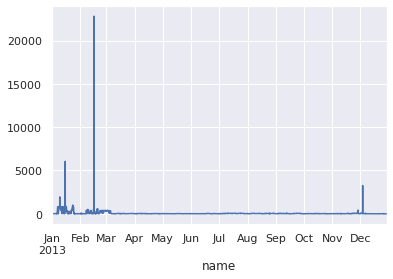

In [63]:
#Understanding why the LCOS is so high
elec_price['GB4 0'].loc[n.snapshots[0]:n.snapshots[8700]].plot()
#elec_price.max()

In [64]:
elec_price = elec_price.reset_index(drop=True) ##clears row index
elec_price = elec_price.transpose().reset_index(drop=True) ##clear column index
elec_price = elec_price.transpose() #transpose back to original shape

charging_energy = charging_energy.reset_index(drop=True) ##clears row index
charging_energy = charging_energy.transpose().reset_index(drop=True) ##clear column index
charging_energy = charging_energy.transpose() #transpose back to original shape

charging_cost = charging_energy.loc[:] * elec_price.loc[:]  # charging cost per bus with time information
charging_cost = charging_cost.sum() # charging cost per bus
charging_cost.head()


0    1.589937e+06
1    1.380736e+05
2    9.385990e+05
3    8.754544e+04
4    6.156934e+06
dtype: float64

LCOS-calculation: [€/MWh]

In [65]:
LCOS_low_case = (CAPEX+charging_cost)/total_discharged_amount
CAPEX_low_LCOS = CAPEX
charging_cost_low_LCOS = charging_cost
#LCOS_low_case

Market-size calculation: \
[MW] discharge_unit = charging_unit,  
[MWh] capacity = max_hours*discharge_unit

In [66]:
#market-size per bus
market_size_electrolysor_low_LCOS = installed_capacity_electrolysor_low_LCOS.reset_index(drop=True)
market_size_fuel_cell_low_LCOS = installed_capacity_fuel_cell_low_LCOS.reset_index(drop=True)
market_size_H2_storage_low_LCOS = installed_capacity_H2_storage_low_LCOS.reset_index(drop=True)


Full-load-hour calculation:

In [67]:
# discharged net amount per bus [MWh] / effective built discharge unit [MW]

In [68]:
nom_install_capacity = market_size_fuel_cell_low_LCOS
eff_install_capacity = market_size_fuel_cell_low_LCOS * dispatch_effi
eff_install_capacity = eff_install_capacity.reset_index(drop=True)

In [69]:
FLH_low_LCOS = total_discharged_amount / eff_install_capacity
#FLH_low_LCOS

# Improved high LCOS calculation

In [70]:
# LCOS = capital_cost / total_discharge_amount + charging_cost / total_discharge_amount

In [71]:
# CAPEX = capital_cost(€/MW)*p.nom.max(MW)

In [72]:
# total_discharge_amount = p.dispatch.sum[MWh]*dispatch_efficiency

In [73]:
#WAY1 charging_cost = Energy_out*effi_RT*el_price ((BUT WHAT IS THE ELECTRICITY PRICE))

In [74]:
#WAY2 charging_cost = Energy_in*el_price

CAPEX-calculation: [€/year]

In [75]:
# CAPEX = capital_cost(€/MW)*p.nom.max(MW)

In [76]:
# LCOS = capital_cost / total_discharge_amount + charging_cost / total_discharge_amount

In [77]:
# CAPEX = capital_cost(€/MW)*p.nom.max(MW)

In [78]:
# total_discharge_amount = p.dispatch.sum[MWh]*dispatch_efficiency

In [79]:
#WAY1 charging_cost = Energy_out*effi_RT*el_price ((BUT WHAT IS THE ELECTRICITY PRICE))

In [80]:
#WAY2 charging_cost = Energy_in*el_price

CAPEX-calculation: [€/year]

In [81]:
# CAPEX = capital_cost(€/MW)*p.nom.max(MW)

In [82]:
storage_comp = n.links.iloc[42:] 

In [83]:
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 electrolysis-low-LCOS'])].iloc[:,:]
installed_capacity_electrolysor_low_LCOS = pie_components.groupby(["bus0", "carrier"]).p_nom_opt.sum()
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 fuel cell-low-LCOS'])].iloc[:,:]
installed_capacity_fuel_cell_low_LCOS = pie_components.groupby(["bus1", "carrier"]).p_nom_opt.sum()
pie_components = n.stores.loc[n.stores['carrier'].apply(lambda x: x in ['H2-scenario-l-LCOS'])].iloc[:,:]
installed_capacity_H2_storage_low_LCOS = pie_components.groupby(["bus", "carrier"]).e_nom_opt.sum()

In [84]:
installed_capacity_electrolysor_low_LCOS = installed_capacity_electrolysor_low_LCOS.reset_index(drop=True)
installed_capacity_fuel_cell_low_LCOS = installed_capacity_fuel_cell_low_LCOS.reset_index(drop=True)
installed_capacity_H2_storage_low_LCOS = installed_capacity_H2_storage_low_LCOS.reset_index(drop=True)

In [85]:
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 electrolysis-low-LCOS'])].iloc[:,:]
CAPEX_Fom_electrolysor_low_LCOS = pie_components.groupby(["bus0", "carrier"]).capital_cost.sum()
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 fuel cell-low-LCOS'])].iloc[:,:]
CAPEX_Fom_fuel_cell_low_LCOS = pie_components.groupby(["bus1", "carrier"]).capital_cost.sum()
pie_components = n.stores.loc[n.stores['carrier'].apply(lambda x: x in ['H2-scenario-l-LCOS'])].iloc[:,:]
CAPEX_Fom_H2_storage_low_LCOS = pie_components.groupby(["bus", "carrier"]).capital_cost.sum()

In [86]:
CAPEX_Fom_electrolysor_low_LCOS = CAPEX_Fom_electrolysor_low_LCOS.reset_index(drop=True)
CAPEX_Fom_fuel_cell_low_LCOS = CAPEX_Fom_fuel_cell_low_LCOS.reset_index(drop=True)
CAPEX_Fom_H2_storage_low_LCOS = CAPEX_Fom_H2_storage_low_LCOS.reset_index(drop=True)

In [87]:
CAPEX = (installed_capacity_electrolysor_low_LCOS * CAPEX_Fom_electrolysor_low_LCOS + 
        installed_capacity_fuel_cell_low_LCOS * CAPEX_Fom_fuel_cell_low_LCOS + 
        installed_capacity_H2_storage_low_LCOS * CAPEX_Fom_H2_storage_low_LCOS)
#CAPEX  #[€/year]

In [88]:
storage_comp = n.links.iloc[42:]
#storage_comp

In [89]:
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 electrolysis-high-LCOS'])].iloc[:,:]
installed_capacity_electrolysor_high_LCOS = pie_components.groupby(["bus0", "carrier"]).p_nom_opt.sum()
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 fuel cell-high-LCOS'])].iloc[:,:]
installed_capacity_fuel_cell_high_LCOS = pie_components.groupby(["bus1", "carrier"]).p_nom_opt.sum()
pie_components = n.stores.loc[n.stores['carrier'].apply(lambda x: x in ['H2-scenario-h-LCOS'])].iloc[:,:]
installed_capacity_H2_storage_high_LCOS = pie_components.groupby(["bus", "carrier"]).e_nom_opt.sum()

In [90]:
installed_capacity_electrolysor_high_LCOS = installed_capacity_electrolysor_high_LCOS.reset_index(drop=True)
installed_capacity_fuel_cell_high_LCOS = installed_capacity_fuel_cell_high_LCOS.reset_index(drop=True)
installed_capacity_H2_storage_high_LCOS = installed_capacity_H2_storage_high_LCOS.reset_index(drop=True)

In [91]:
#installed_capacity_electrolysor_high_LCOS

In [92]:
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 electrolysis-high-LCOS'])].iloc[:,:]
CAPEX_Fom_electrolysor_high_LCOS = pie_components.groupby(["bus0", "carrier"]).capital_cost.sum()
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['H2 fuel cell-high-LCOS'])].iloc[:,:]
CAPEX_Fom_fuel_cell_high_LCOS = pie_components.groupby(["bus1", "carrier"]).capital_cost.sum()
pie_components = n.stores.loc[n.stores['carrier'].apply(lambda x: x in ['H2-scenario-h-LCOS'])].iloc[:,:]
CAPEX_Fom_H2_storage_high_LCOS = pie_components.groupby(["bus", "carrier"]).capital_cost.sum()

In [93]:
CAPEX_Fom_electrolysor_high_LCOS = CAPEX_Fom_electrolysor_high_LCOS.reset_index(drop=True)
CAPEX_Fom_fuel_cell_high_LCOS = CAPEX_Fom_fuel_cell_high_LCOS.reset_index(drop=True)
CAPEX_Fom_H2_storage_high_LCOS = CAPEX_Fom_H2_storage_high_LCOS.reset_index(drop=True)

In [94]:
CAPEX = (installed_capacity_electrolysor_high_LCOS * CAPEX_Fom_electrolysor_high_LCOS + 
        installed_capacity_fuel_cell_high_LCOS * CAPEX_Fom_fuel_cell_high_LCOS + 
        installed_capacity_H2_storage_high_LCOS * CAPEX_Fom_H2_storage_high_LCOS)
#CAPEX  #[€/year]

Total-discharge-amount calculation: [MWh/year]

In [95]:
# total_discharge_amount = p.dispatch.sum[MWh]*dispatch_efficiency

In [96]:
#costs = pd.read_csv('/home/max/OneDrive/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/costs.csv')
#costs = pd.read_csv('C:/Users/Max/OneDrive - University of Edinburgh/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/costs.csv')
dispatch_effi = costs.iloc[98]['value']

In [97]:
# total_discharged_amount = n.links_t.p0.filter(like='H2-scenario-h-LCOS Fuel Cell-high-LCOS', axis='columns').sum()
# total_discharged_amount = total_discharged_amount*dispatch_effi
# total_discharged_amount = total_discharged_amount.reset_index(drop=True)
# total_discharged_amount.sum() #[MWh/year]
total_discharged_amount = total_discharged_amount_h

In [98]:
total_charged_amount = n.links_t.p0.filter(like='H2-scenario-h-LCOS Electrolysis-high-LCOS', axis='columns').sum()
total_charged_amount = total_charged_amount.reset_index(drop=True)
total_charged_amount.sum() #[MWh/year]


126303164.95503876

Charging-cost calculcation: [€]

In [99]:
#WAY2 charging_cost = Energy_in(t)*el_price(t)

In [100]:
#costs = pd.read_csv('/home/max/OneDrive/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/costs.csv')
#store_effi = costs.iloc[94]['value']
#store_effi

#### Not necessary with store and link all the efficiecies are already implemented.
## p0 (elec bus) -> p1 (storage) charging
## p0(storage) -> p1 (elec bus) discharging 

In [101]:
#charging_energy = n.links_t.p0.filter(like='H2-scenario-h-LCOS Electrolysis-high-LCOS', axis='columns')
charging_energy = charging_energy_h
column_index = charging_energy.transpose().index

#Loop to replace all values below 10 by "0"
for item in range(0,len(column_index)): 
    boolean_condition = charging_energy[charging_energy.transpose().index[item]] < 1
    column_name = column_index[item]
    new_value = 0
    charging_energy.loc[boolean_condition, column_name] = new_value

charging_energy.head()

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
name,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,1.935382,2.218576,0.000000,0.000000,39.506406,27.094802,12.156355,488.106931,32.372934,10.123813,...,6.589407,5.966770,9.311462,20.971499,6.527708,5.523008,5.278600,5.336783,2.849072,0.0
2013-01-01 01:00:00,1.942510,2.233257,0.000000,0.000000,35.156917,26.991955,12.045120,488.061072,32.272303,10.019941,...,6.597280,5.971453,9.337883,20.973307,6.538456,5.515952,5.278235,5.334599,2.991885,0.0
2013-01-01 02:00:00,3.470462,2.245513,0.000000,0.000000,40.404622,26.921797,12.002333,488.007573,32.216808,9.975808,...,6.601565,5.997260,9.358040,20.970832,6.556944,5.514374,5.278034,5.355142,3.296297,0.0
2013-01-01 03:00:00,2.582433,2.264818,0.000000,0.000000,31.437664,26.622586,11.826583,487.792627,31.987971,9.796454,...,6.604475,6.006664,9.371063,20.966436,6.570429,5.520856,5.278246,5.392026,3.282727,0.0
2013-01-01 04:00:00,2.499158,2.254630,1.768655,1.104017,26.873514,25.394842,11.678976,484.855750,31.537079,9.598863,...,6.606817,6.014688,9.369836,20.964989,6.580237,5.525179,5.281192,5.409946,3.366718,0.0


In [102]:
elec_price = n.buses_t.marginal_price.iloc[:,0:len(column_index)]
#elec_price.head()

<AxesSubplot:xlabel='name'>

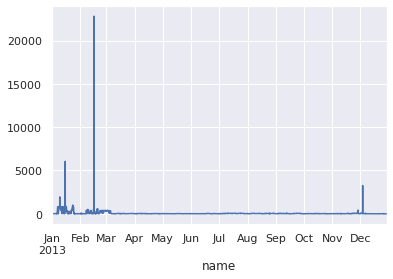

In [103]:
#Understanding why the LCOS is so high
elec_price['GB4 0'].loc[n.snapshots[0]:n.snapshots[8700]].plot()
#elec_price.max()

In [104]:
elec_price = elec_price.reset_index(drop=True) ##clears row index
elec_price = elec_price.transpose().reset_index(drop=True) ##clear column index
elec_price = elec_price.transpose() #transpose back to original shape

charging_energy = charging_energy.reset_index(drop=True) ##clears row index
charging_energy = charging_energy.transpose().reset_index(drop=True) ##clear column index
charging_energy = charging_energy.transpose() #transpose back to original shape

charging_cost = charging_energy.loc[:] * elec_price.loc[:]  # charging cost per bus with time information
charging_cost = charging_cost.sum() # charging cost per bus
charging_cost.head()


0    4.582848e+06
1    2.381689e+05
2    3.032250e+05
3    1.175542e+05
4    4.113185e+06
dtype: float64

LCOS-calculation: [€/MWh]

In [105]:
LCOS_high_case = (CAPEX+charging_cost)/total_discharged_amount
CAPEX_high_LCOS = CAPEX
charging_cost_high_LCOS = charging_cost
#LCOS_low_case

Market-size calculation: \
[MW] discharge_unit = charging_unit,  
[MWh] capacity = max_hours*discharge_unit

In [106]:
#market-size per bus
market_size_electrolysor_high_LCOS = installed_capacity_electrolysor_high_LCOS.reset_index(drop=True)
market_size_fuel_cell_high_LCOS = installed_capacity_fuel_cell_high_LCOS.reset_index(drop=True)
market_size_H2_storage_high_LCOS = installed_capacity_H2_storage_high_LCOS.reset_index(drop=True)


Full-load-hour calculation:

In [107]:
# discharged net amount per bus [MWh] / effective built discharge unit [MW]

In [108]:
nom_install_capacity = market_size_fuel_cell_high_LCOS
eff_install_capacity = market_size_fuel_cell_high_LCOS * dispatch_effi
eff_install_capacity = eff_install_capacity.reset_index(drop=True)

In [109]:
nom = market_size_electrolysor_high_LCOS
store_effi = costs.iloc[94]['value']
#store_effi*
eff = nom * store_effi
eff = eff.reset_index(drop=True)

In [110]:
FLH_high_LCOS = total_discharged_amount / eff_install_capacity
#FLH_low_LCOS
FLH_charged = total_charged_amount / (eff)
FLH_charged.mean()

3998.917573934574

# Improved Battery LCOS calculation

In [111]:
# LCOS = capital_cost / total_discharge_amount + charging_cost / total_discharge_amount

In [112]:
# CAPEX = capital_cost(€/MW)*p.nom.max(MW)

In [113]:
# total_discharge_amount = p.dispatch.sum[MWh]*dispatch_efficiency

In [114]:
#WAY1 charging_cost = Energy_out*effi_RT*el_price ((BUT WHAT IS THE ELECTRICITY PRICE))

In [115]:
#WAY2 charging_cost = Energy_in*el_price

CAPEX-calculation: [€/year]

In [116]:
# CAPEX = capital_cost(€/MW)*p.nom.max(MW)

In [117]:
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['battery discharger'])].iloc[:,:]
installed_capacity_inverter = pie_components.groupby(["bus0", "carrier"]).p_nom_opt.sum()
pie_components = n.stores.loc[n.stores['carrier'].apply(lambda x: x in ['battery'])].iloc[:,:]
installed_capacity_battery = pie_components.groupby(["bus", "carrier"]).e_nom_opt.sum()

In [118]:
installed_capacity_inverter = installed_capacity_inverter.reset_index(drop=True)
installed_capacity_battery = installed_capacity_battery.reset_index(drop=True)

In [119]:
pie_components = storage_comp.loc[storage_comp['carrier'].apply(lambda x: x in ['battery discharger'])].iloc[:,:]
CAPEX_Fom_inverter = pie_components.groupby(["bus0", "carrier"]).capital_cost.sum()
pie_components = n.stores.loc[n.stores['carrier'].apply(lambda x: x in ['battery'])].iloc[:,:]
CAPEX_Fom_battery = pie_components.groupby(["bus", "carrier"]).capital_cost.sum()

In [120]:
CAPEX_Fom_inverter = CAPEX_Fom_inverter.reset_index(drop=True)
CAPEX_Fom_battery = CAPEX_Fom_battery.reset_index(drop=True)

In [121]:
CAPEX = (installed_capacity_inverter * CAPEX_Fom_inverter +  
        installed_capacity_battery * CAPEX_Fom_battery)
#CAPEX  #[€/year]
#CAPEX

Total-discharge-amount calculation: [MWh/year]

In [122]:
# total_discharge_amount = p.dispatch.sum[MWh]*dispatch_efficiency

In [123]:
#costs = pd.read_csv('/home/max/OneDrive/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/costs.csv')
#costs = pd.read_csv('C:/Users/Max/OneDrive - University of Edinburgh/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/costs.csv')
dispatch_effi = (costs.iloc[217]['value'])
dispatch_effi

0.9

In [124]:
# total_discharged_amount = -(n.links_t.p1.filter(like='battery discharger', axis='columns').sum())
# total_discharged_amount = total_discharged_amount.reset_index(drop=True)
# total_discharged_amount.sum() #[MWh/year]
total_discharged_amount = total_discharged_amount_b

In [125]:
total_discharged_amount_b.shape

(181,)

Charging-cost calculcation: [€]

In [126]:
#WAY2 charging_cost = Energy_in(t)*el_price(t)

In [127]:
#costs = pd.read_csv('/home/max/OneDrive/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/costs.csv')
#store_effi = costs.iloc[94]['value']
#store_effi

#### Not necessary with store and link all the efficiecies are already implemented.
## p0 (elec bus) -> p1 (storage) charging
## p0(storage) -> p1 (elec bus) discharging 

In [128]:
#charging_energy = n.links_t.p0.filter(like='battery charger', axis='columns')
charging_energy = charging_energy_b
column_index = charging_energy.transpose().index

#Loop to recharging_energy place all values below 10 by "0"
for item in range(0,len(column_index)): 
    boolean_condition = charging_energy[charging_energy.transpose().index[item]] < 1
    column_name = column_index[item]
    new_value = 0
    charging_energy.loc[boolean_condition, column_name] = new_value

charging_energy.head()

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
name,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,1.980274,2.035697,1.928300,1.97719,1.925281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,1.053158,0.000000,1.365131,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
elec_price = n.buses_t.marginal_price.iloc[:,0:len(column_index)]
#elec_price.head()

<AxesSubplot:xlabel='name'>

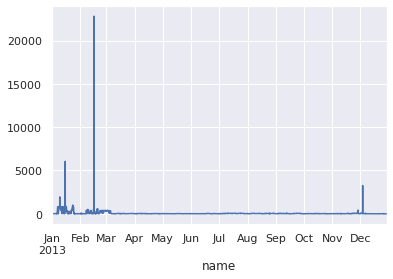

In [130]:
#Understanding why the LCOS is so high
elec_price['GB4 0'].loc[n.snapshots[0]:n.snapshots[8700]].plot()
#elec_price.max()

In [131]:
elec_price = elec_price.reset_index(drop=True) ##clears row index
elec_price = elec_price.transpose().reset_index(drop=True) ##clear column index
elec_price = elec_price.transpose() #transpose back to original shape

charging_energy = charging_energy.reset_index(drop=True) ##clears row index
charging_energy = charging_energy.transpose().reset_index(drop=True) ##clear column index
charging_energy = charging_energy.transpose() #transpose back to original shape

charging_cost = charging_energy.loc[:] * elec_price.loc[:]  # charging cost per bus with time information
charging_cost = charging_cost.sum() # charging cost per bus
charging_cost.head()

0    2.080445e+06
1    4.871501e+04
2    2.459448e+05
3    1.399925e+05
4    1.616473e+06
dtype: float64

LCOS-calculation: [€/MWh]

In [132]:
LCOS_battery = (CAPEX+charging_cost)/total_discharged_amount
CAPEX_battery = CAPEX
charging_cost_battery = charging_cost
#LCOS_low_case

Market-size calculation: \
[MW] discharge_unit = charging_unit,  
[MWh] capacity = max_hours*discharge_unit

In [133]:
#market-size per bus
market_size_inverter = installed_capacity_inverter.reset_index(drop=True)
market_size_battery = installed_capacity_battery.reset_index(drop=True)

Full-load-hour calculation:

In [134]:
# discharged net amount per bus [MWh] / effective built discharge unit [MW]

In [135]:
nom_install_capacity = market_size_inverter
eff_install_capacity = nom_install_capacity * dispatch_effi
eff_install_capacity = eff_install_capacity.reset_index(drop=True)

In [136]:
FLH_battery = total_discharged_amount / eff_install_capacity
#FLH_low_LCOS

### LCOS plot

In [137]:
### JUST TO GET THE NODE INDEX BACK (i.e. DE0 1)
charging_energy = n.links_t.p0.filter(like='battery charger', axis='columns')
index_filter = charging_energy.transpose().index
index_clean = index_filter.str[:6]
index_clean.values.shape

(181,)

In [138]:
bus_load_annual_energy = n.loads_t.p_set.sum().reset_index(drop=True)
bus_load_peak_capacity = n.loads_t.p_set.max().reset_index(drop=True)
#bus_load_peak_capacity 

In [139]:
len(LCOS_high_case.values)

181

In [140]:
df_high_LCOS = pd.DataFrame(data=LCOS_high_case.values,columns=['LCOS'])
df_high_LCOS['unit']='H2-high-LCOS'
df_high_LCOS['country']= index_clean
df_high_LCOS['market_size_charge']= market_size_electrolysor_high_LCOS
df_high_LCOS['market_size_storage']= market_size_H2_storage_high_LCOS
df_high_LCOS['market_size_discharge']= market_size_fuel_cell_high_LCOS
df_high_LCOS['E/P ratio charge']= market_size_H2_storage_high_LCOS/market_size_electrolysor_high_LCOS
df_high_LCOS['E/P ratio discharge']= market_size_H2_storage_high_LCOS/market_size_fuel_cell_high_LCOS
df_high_LCOS['FLH']= FLH_high_LCOS
df_high_LCOS['Annual cycles'] = FLH_high_LCOS/df_high_LCOS['E/P ratio discharge']
df_high_LCOS['Installed power to yearly peak load'] = (market_size_fuel_cell_high_LCOS/bus_load_peak_capacity)    #storage power installed to peak load at bus
df_high_LCOS['Installed energy to yearly load'] =  market_size_H2_storage_high_LCOS/bus_load_annual_energy       #storage energy to yearly load at bus
df_high_LCOS['CAPEX']= CAPEX_high_LCOS
df_high_LCOS['charging_costs']= charging_cost_high_LCOS

In [141]:
### JUST TO GET THE NODE INDEX BACK (i.e. DE0 1)
charging_energy = n.links_t.p0.filter(like='battery charger', axis='columns')
index_filter = charging_energy.transpose().index
index_clean = index_filter.str[:6]
index_clean.values.shape

(181,)

In [142]:
df_low_LCOS = pd.DataFrame(data=LCOS_low_case.values,columns=['LCOS'])
df_low_LCOS['unit']='H2-low-LCOS'
df_low_LCOS['country']= index_clean
df_low_LCOS['market_size_charge']= market_size_electrolysor_low_LCOS
df_low_LCOS['market_size_storage']= market_size_H2_storage_low_LCOS
df_low_LCOS['market_size_discharge']= market_size_fuel_cell_low_LCOS
df_low_LCOS['E/P ratio charge']= market_size_H2_storage_low_LCOS/market_size_electrolysor_low_LCOS
df_low_LCOS['E/P ratio discharge']= market_size_H2_storage_low_LCOS/market_size_fuel_cell_low_LCOS
df_low_LCOS['FLH']= FLH_low_LCOS
df_low_LCOS['Annual cycles'] = FLH_low_LCOS/df_low_LCOS['E/P ratio discharge']
df_low_LCOS['Installed power to yearly peak load'] = (market_size_fuel_cell_low_LCOS/bus_load_peak_capacity)    #storage power installed to peak load at bus
df_low_LCOS['Installed energy to yearly load'] =  market_size_H2_storage_low_LCOS/bus_load_annual_energy       #storage energy to yearly load at bus
df_low_LCOS['CAPEX']= CAPEX_low_LCOS
df_low_LCOS['charging_costs']= charging_cost_low_LCOS

In [143]:
### JUST TO GET THE NODE INDEX BACK (i.e. DE0 1)
charging_energy = n.links_t.p0.filter(like='battery charger', axis='columns')
index_filter = charging_energy.transpose().index
index_clean = index_filter.str[:6]
index_clean.values.shape


(181,)

In [144]:
index_clean
market_size_inverter
LCOS_battery.values

array([130.15782071, 222.58247279, 184.76928617, 200.2184214 ,
       141.68339763, 253.2982708 , 271.46516897, 262.32822098,
       256.68933346, 262.08454123, 158.74586142, 156.79666446,
       221.79692819, 248.99437488, 219.34781202, 212.34289303,
       204.7622259 , 200.43506948, 222.53986193, 235.48775559,
       239.26607465, 232.68058967, 309.70023895, 243.14127399,
       223.10311119, 246.02502569, 268.48094029, 260.93307838,
       302.67986907, 284.48456277, 303.94668994, 214.38946947,
       243.84754464, 273.54782409, 225.51961517, 249.57346726,
       276.87678707, 270.83031312, 269.85990068, 242.8077375 ,
       220.63271455, 240.6537632 , 280.91250777, 286.61016818,
       267.08053124, 285.52978946, 245.88905532, 161.10952931,
       164.73015473, 154.66942027, 167.55401771, 164.29472408,
       164.5225361 , 167.98606185, 161.73213752, 148.58381068,
       158.94002366, 167.26187293, 167.04811996, 164.63077876,
       166.93762465, 137.36001901, 334.64519799, 320.66

In [145]:
df_battery = pd.DataFrame(data=LCOS_battery.values,columns=['LCOS'])
df_battery['unit']='battery'
##I need a discharger, inverter index'
df_battery['country']= index_clean
df_battery['market_size_charge']= market_size_inverter #both charge and discharge market size
df_battery['market_size_storage']= market_size_battery
df_battery['market_size_discharge']= market_size_inverter #both charge and discharge market size
df_battery['E/P ratio charge']= market_size_battery/market_size_inverter
df_battery['E/P ratio discharge']= market_size_battery/market_size_inverter
df_battery['FLH']= FLH_battery
df_battery['Annual cycles'] = FLH_battery/df_battery['E/P ratio discharge']
df_battery['Installed power to yearly peak load'] = (market_size_inverter/bus_load_peak_capacity)    #storage power installed to peak load at bus
df_battery['Installed energy to yearly load'] =  market_size_battery/bus_load_annual_energy       #storage energy to yearly load at bus
df_battery['CAPEX']= CAPEX_battery
df_battery['charging_costs']= charging_cost_battery
#df_battery

In [146]:
#Combine both tables
iris = df_low_LCOS.append(df_high_LCOS, ignore_index=True, sort=False)
iris = iris.append(df_battery, ignore_index=True, sort=False)

In [147]:
iris.shape

(543, 14)

In [148]:
#delete rows with market size below 10 and formatting

indexNames = iris[(iris['market_size_charge'] <= 10) | 
                   (iris['market_size_storage'] <= 1) |
                   (iris['market_size_discharge'] <= 10) |
                  (iris['FLH'] <= 80)].index
iris = iris.drop(indexNames)




In [149]:
iris

,LCOS,unit,country,market_size_charge,market_size_storage,market_size_discharge,E/P ratio charge,E/P ratio discharge,FLH,Annual cycles,Installed power to yearly peak load,Installed energy to yearly load,CAPEX,charging_costs
0,363.875059,H2-low-LCOS,AL0 0,37.941844,2861.089402,103.963538,75.407231,27.520123,406.349802,14.765552,0.122882,0.000640,5.634953e+06,1.589937e+06
4,582.065033,H2-low-LCOS,BA0 0,127.521773,14039.570159,916.223117,110.095475,15.323309,151.877555,9.911538,0.441766,0.001132,3.191143e+07,6.156934e+06
5,552.753115,H2-low-LCOS,BE0 0,100.732188,19986.694535,680.614957,198.414181,29.365641,186.945966,6.366146,0.250972,0.001165,2.973456e+07,3.321159e+06
6,605.928802,H2-low-LCOS,BE0 1,14.117085,2756.548587,83.726522,195.263303,32.923242,185.683640,5.639895,0.061635,0.000321,3.928095e+06,4.993806e+05
7,518.287907,H2-low-LCOS,BE0 2,109.693511,21689.097033,715.027414,197.724521,30.333238,206.740401,6.815639,0.167069,0.000801,3.185826e+07,4.151232e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,121.753922,battery,IT0 7,52.500937,173.852910,52.500937,3.311425,3.311425,1448.409924,437.397787,0.026135,0.000015,4.929665e+06,3.403002e+06
498,126.833934,battery,IT1 0,64.373688,245.598144,64.373688,3.815195,3.815195,1628.907598,426.952694,0.023438,0.000015,6.698285e+06,5.271403e+06
502,133.680922,battery,ME0 0,31.540291,102.420229,31.540291,3.247282,3.247282,1445.026940,444.995777,0.050790,0.000030,2.920742e+06,2.562704e+06
531,142.721164,battery,RS0 0,11.015551,34.578009,11.015551,3.139018,3.139018,1343.391366,427.965521,0.003263,0.000002,9.960352e+05,9.047789e+05


/home/max/anaconda3/envs/pypsa-eur/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='unit', ylabel='E/P ratio charge'>

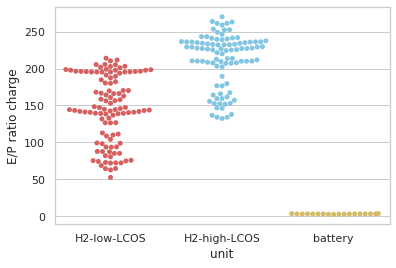

In [150]:
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

# Load the example iris dataset
# iris = sns.load_dataset("iris")

# "Melt" the dataset to "long-form" or "tidy" representation
#iris = pd.melt(iris, "country", var_name="unit")

# Draw a categorical scatterplot to show each observation
sns.swarmplot(x="unit", y="E/P ratio charge",
              palette=["r", "c", "y"], data=iris)

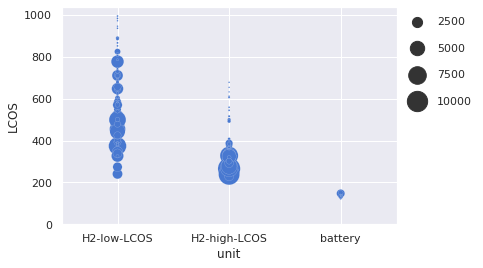

In [151]:
import seaborn as sns
sns.set(style="darkgrid", palette="muted")

# Load the example planets dataset
#planets = sns.load_dataset("planets")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x="unit", y="LCOS",
                     size="market_size_discharge",
                     palette=cmap, sizes=(1, 500),
                     data=iris)

plt.ylim(0, None)
plt.xlim(-0.5, 2.5)
plt.legend(labelspacing=20)
# 5. Place legend to the right
plt.legend(bbox_to_anchor=(1, 1), loc=2, frameon = False, labelspacing = 1.5)

In [169]:
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(10,6))
sns.color_palette("PuBuGn_d")
sns.violinplot(data=iris, 
               x="unit", 
               y="LCOS", 
               palette="PuBuGn_d",
               bw=.8, 
               linewidth=0.1, 
               inner = None)

sns.scatterplot(x="unit", 
                y="LCOS",
                size="market_size_discharge",
                palette="Blues_r", 
                alpha=0.7,
                sizes=(10, 500),
                hue="FLH",
                data=iris,
                )
#Labels
ax.set(xlabel=None, ylabel = "LCOS [ct/kWh]")

plt.ylim(0, )
plt.xlim(-0.5, 2.5)

# 5. Place legend to the right
plt.legend(bbox_to_anchor=(1, 1), loc=2, frameon = False, labelspacing = 1.5)

#plt.savefig('Big3-LCOS-range-var-EP-ratio.svg', bbox_inches="tight")

AttributeError: 'Styler' object has no attribute 'get'

<Figure size 720x432 with 0 Axes>

In [153]:
iris_h2_low = iris[iris.unit != 'battery']
iris_h2_low = iris_h2_low[iris_h2_low.unit != 'H2-high-LCOS']
#iris_h2_low


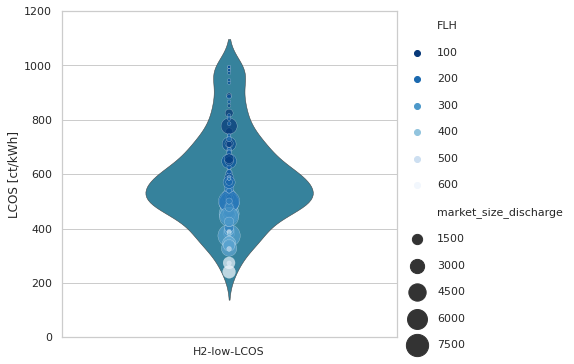

In [168]:
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(6,6))
sns.color_palette("PuBuGn_d")
ax = sns.violinplot(data=iris_h2_low, 
               x="unit", 
               y="LCOS", 
               palette="PuBuGn_d",
               bw=.3, 
               linewidth=0.5,
               width = 0.5,
               inner = None)

ax = sns.scatterplot(x="unit", 
                y="LCOS",
                size="market_size_discharge",
                palette="Blues_r", 
                alpha=0.7,
                sizes=(10, 500),
                hue="FLH",
                data=iris_h2_low,
                )
#Labels
ax.set(xlabel=None, ylabel = "LCOS [ct/kWh]")

plt.ylim(0, 1200)
plt.xlim(-0.5, 0.5)

# 5. Place legend to the right
plt.legend(bbox_to_anchor=(1, 1), loc=2, frameon = False, labelspacing = 1.5)

#plt.savefig('H2-low_LCOS.svg', bbox_inches="tight")

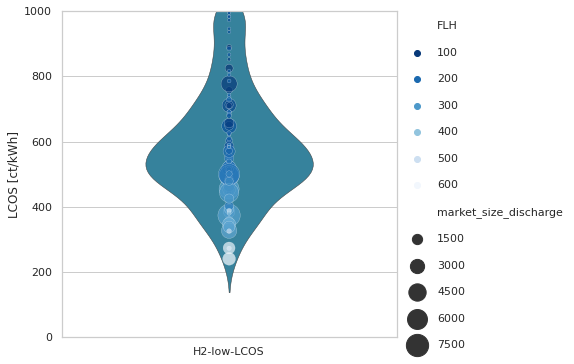

In [155]:
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(6,6))
sns.color_palette("PuBuGn_d")
ax = sns.violinplot(data=iris_h2_low, 
               x="unit", 
               y="LCOS", 
               palette="PuBuGn_d",
               bw=.3, 
               linewidth=0.5,
               width = 0.5,
               inner = None)

ax = sns.scatterplot(x="unit", 
                y="LCOS",
                size="market_size_discharge",
                palette="Blues_r", 
                alpha=0.7,
                sizes=(10, 500),
                hue="FLH",
                data=iris_h2_low,
                )
#Labels
ax.set(xlabel=None, ylabel = "LCOS [ct/kWh]")

plt.ylim(0, 1000)
plt.xlim(-0.5, 0.5)

# 5. Place legend to the right
plt.legend(bbox_to_anchor=(1, 1), loc=2, frameon = False, labelspacing = 1.5)

#plt.savefig('H2-low_LCOS.svg', bbox_inches="tight")

In [156]:
iris_h2_high = iris[iris.unit != 'battery']
iris_h2_high = iris_h2_high[iris_h2_high.unit != 'H2-low-LCOS']
#iris_h2_low

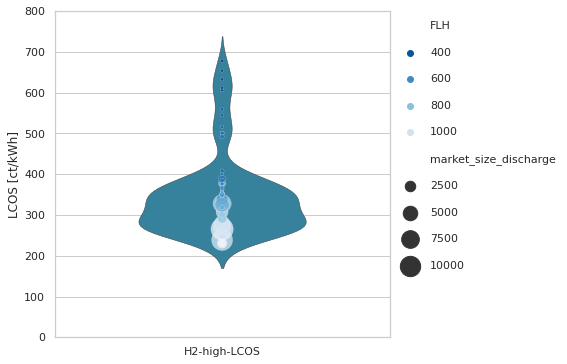

In [157]:
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(6,6))
sns.color_palette("PuBuGn_d")
ax = sns.violinplot(data=iris_h2_high, 
               x="unit", 
               y="LCOS", 
               palette="PuBuGn_d",
               bw=.3, 
               linewidth=0.5,
               width = 0.5,
               inner = None)

ax = sns.scatterplot(x="unit", 
                y="LCOS",
                size="market_size_discharge",
                palette="Blues_r", 
                alpha=0.7,
                sizes=(10, 500),
                hue="FLH",
                data=iris_h2_high,
                )
#Labels
ax.set(xlabel=None, ylabel = "LCOS [ct/kWh]")

plt.ylim(0, 800)
plt.xlim(-0.5, 0.5)

# 5. Place legend to the right
plt.legend(bbox_to_anchor=(1, 1), loc=2, frameon = False, labelspacing = 1.5)

#plt.savefig('H2-high_LCOS.svg', bbox_inches="tight")

In [159]:
iris_battery = iris[iris.unit != 'H2-low-LCOS']
iris_battery = iris_battery[iris_battery.unit != 'H2-high-LCOS']
#iris_battery

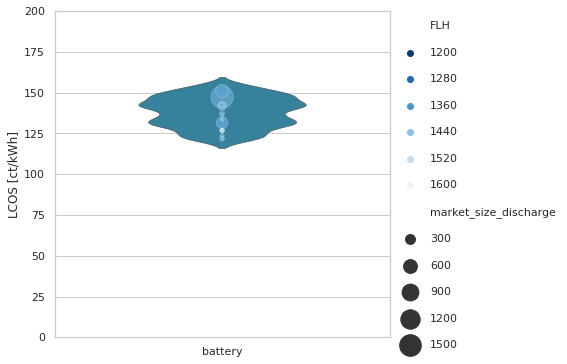

In [160]:
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(6,6))
sns.color_palette("PuBuGn_d")
ax = sns.violinplot(data=iris_battery, 
               x="unit", 
               y="LCOS", 
               palette="PuBuGn_d",
               bw=.3, 
               linewidth=0.5,
               width = 0.5,
               inner = None)

ax = sns.scatterplot(x="unit", 
                y="LCOS",
                size="market_size_discharge",
                palette="Blues_r", 
                alpha=0.7,
                sizes=(10, 500),
                hue="FLH",
                data=iris_battery,
                )
#Labels
ax.set(xlabel=None, ylabel = "LCOS [ct/kWh]")

plt.ylim(0, 200)
plt.xlim(-0.5, 0.5)

# 5. Place legend to the right
plt.legend(bbox_to_anchor=(1, 1), loc=2, frameon = False, labelspacing = 1.5)

#plt.savefig('battery.svg', bbox_inches="tight")

### Energy storage statistics
- E/P ratio: bus wise and aggregated, per technology and in total 
- Annual cycles: bus wise and aggregated, per technology and in total 
- Storage-power-to-load-peak ratio: bus wise and aggregated, per technology and in total 
- Storage-energy-to-yearly-load: bus wise and aggregated, per technology and in total 
- FLH: bus wise and aggregated, per technology and in total
- market size per component

In [161]:
iris.groupby(['unit']).sum().market_size_charge

unit
H2-high-LCOS    43256.027213
H2-low-LCOS     23157.771839
battery          3562.088476
Name: market_size_charge, dtype: float64

In [162]:
iris.groupby(['unit']).sum().market_size_storage

unit
H2-high-LCOS    9.694240e+06
H2-low-LCOS     3.228660e+06
battery         1.155298e+04
Name: market_size_storage, dtype: float64

In [163]:
iris.groupby(['unit']).sum().market_size_discharge

unit
H2-high-LCOS    104624.392899
H2-low-LCOS     108174.571205
battery           3562.088476
Name: market_size_discharge, dtype: float64

In [164]:
##ENERGY STORAGE STATS##

iris = iris.style.format({
    'Installed power to yearly peak load': '{:,.2%}'.format,
    'Installed energy to yearly load': '{:,.2%}'.format,
    'market_size_charge': '{:,.0f}'.format,
    'market_size_storage': '{:,.0f}'.format,
    'market_size_discharge': '{:,.0f}'.format,
    'E/P ratio charge': '{:,.0f}'.format,
    'E/P ratio charge': '{:,.0f}'.format,
    'FLH': '{:,.0f}'.format,
    'Annual cycles': '{:,.0f}'.format,
    'CAPEX': '{:,.0f}'.format,
    'charging_costs': '{:,.0f}'.format,          
})# Format to percentage

In [165]:
iris

,LCOS,unit,country,market_size_charge,market_size_storage,market_size_discharge,E/P ratio charge,E/P ratio discharge,FLH,Annual cycles,Installed power to yearly peak load,Installed energy to yearly load,CAPEX,charging_costs
0,363.875059,H2-low-LCOS,AL0 0,38,"2,861",104,75,27.520123,406,15,12.29%,0.06%,"5,634,953","1,589,937"
4,582.065033,H2-low-LCOS,BA0 0,128,"14,040",916,110,15.323309,152,10,44.18%,0.11%,"31,911,430","6,156,934"
5,552.753115,H2-low-LCOS,BE0 0,101,"19,987",681,198,29.365641,187,6,25.10%,0.12%,"29,734,563","3,321,159"
6,605.928802,H2-low-LCOS,BE0 1,14,"2,757",84,195,32.923242,186,6,6.16%,0.03%,"3,928,095","499,381"
7,518.287907,H2-low-LCOS,BE0 2,110,"21,689",715,198,30.333238,207,7,16.71%,0.08%,"31,858,259","4,151,232"
8,551.452637,H2-low-LCOS,BE0 3,49,"9,491",301,195,31.556700,200,6,11.94%,0.06%,"13,752,052","1,873,637"
9,622.813688,H2-low-LCOS,BE0 4,12,"2,406",75,196,31.907057,178,6,2.95%,0.01%,"3,468,969","450,553"
11,596.230363,H2-low-LCOS,BG0 1,59,"6,621",296,113,22.338730,192,9,9.54%,0.04%,"12,499,205","3,451,480"
16,852.249460,H2-low-LCOS,CZ0 1,10,"1,369",65,133,20.992098,114,5,3.46%,0.01%,"2,557,252","431,309"
19,529.629366,H2-low-LCOS,DE0 1,120,"19,075",495,159,38.499571,245,6,13.65%,0.09%,"26,862,726","3,398,145"


### Generator statistics
- Installed capacity
- Share of total capcity
- Capacity factor
- Curtailments

In [166]:
#generator_stats

In [167]:
generator_stats2 = shares.join(generator_stats.groupby('carrier').Curtailment_in_MWh.sum())
generator_stats2 = generator_stats2.join(generator_stats.groupby('carrier').curtailment_in_percentage.mean())
generator_stats2['Capacity [MW]'] = gen_cap 
generator_stats2

NameError: name 'gen_cap' is not defined

### General energy system statistics
- Total system costs
- Total system costs per load (MWh)
- Network expansion in TWkm and as percentage of existing grid
- Curtailmaint as % of load
- National equity = 80%

In [ ]:
#Curtailment_per_total_load = generator_stats.Curtailment_in_MWh.sum()/n.loads_t.p_set.sum().sum()

In [ ]:
n.links.carrier.apply(lambda x: x=='DC').value_counts()

In [ ]:
df_system_stats = pd.DataFrame(data= [n.objective] ,columns=['Total system costs'])
df_system_stats['Total system costs per load [€/MWh]']= n.objective/n.loads_t.p_set.sum().sum()
df_system_stats['Network expansion as percentage of existing grid']= ((n.lines.s_nom_opt - n.lines.s_nom).sum()+(n.links.iloc[:42].p_nom_opt - n.links.iloc[:42].p_nom).sum())/(n.lines.s_nom.sum()+n.links.iloc[:42].p_nom.sum())
df_system_stats['Curtailment as percentage of load'] = generator_stats2.Curtailment_in_MWh.sum()/n.loads_t.p_set.sum().sum()
df_system_stats

# Dataframe charging/discharging/SOC profiles

Aim it to create a Figure that shows the charging behaviour pattern.
- Applied FFT for battery, alkaline and SOEC (3 graphs)
- Including all 181 buses

Option 1 plot:
- y-axis represent the normalized magnitude (remember Dirac and Parsival Theorem)
- Line thickness is related to bus market potential or magnitude

Option 2 plot:
- y-axis represent the absolute magnitude (=MW)
- Maybe in this way the scale is automatic included

Theory:
- I believe that the FFT can just show which pattern/ frequencies are included but don't give a hint on the scale. Since the superposition of fourier domain frequency magnitudes (composite of postive and negative values) gives the output singal. Therefore, the frequency domain magnitude can be artificial without meaning. Though when someone discharging in the reciprocal pattern the harmonic can the eliminated

Alternative to all bus plotting.
Just try 1 bus. Less cool though.

Plot example: https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot



In [ ]:
n = pypsa.Network("/home/max/OneDrive/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/elec_s_181_ec_lv1.25_Co2L0.0-1H-EQ0.8c.nc")

In [ ]:
#n.links_t.p0.filter(like='Electrolysis-high-LCOS').head()#.p_store

Step 1: Prepare the profiles

In [ ]:
#Cleaning charging data
#Loop to replace all values below 0.1 by "0"
charging_energy = n.links_t.p0.filter(like='Electrolysis-high-LCOS')
column_index = charging_energy.transpose().index

#Loop to replace all values below 0.1 by "0"
for item in range(0,len(column_index)): 
    boolean_condition = charging_energy[charging_energy.transpose().index[item]] < 0.1
    column_name = column_index[item]
    new_value = 0
    charging_energy.loc[boolean_condition, column_name] = new_value

In [ ]:
#charging_energy.tail()
#charging_energy.shape

In [ ]:
#Normalizing charging_energy
charging_energy_normalized = charging_energy/charging_energy.max()

In [ ]:
charging_energy_normalized.iloc[:,0].plot()
plt.xlim()

In [ ]:
#Absolute charging_energy
charging_energy_absolute = charging_energy

Step 2: Create array for a specific column

In [ ]:
index_filter = charging_energy.columns
index_clean = index_filter.str[:6]
timeseries = []
timeseries_list = []


for item in range(0,len(column_index)):
    timeseries = charging_energy_normalized.index
    bus = [index_clean[item]]*len(timeseries)
    store_normalized = charging_energy_normalized.iloc[:,item]
    store_absolute = charging_energy_absolute.iloc[:,item]
    if item == 0:
        timeseries_list = timeseries
        bus_list = bus
        store_normalized_list = store_normalized
        store_absolute_list = store_absolute
    else:
        timeseries_list = timeseries_list.append([timeseries])
        bus_list += bus
        store_normalized_list = store_normalized_list.append(store_normalized)
        store_absolute_list = store_absolute_list.append(store_absolute)
      

In [ ]:
#len(column_index)
timeseries.shape
#[index_clean[item]]
#len(fft)

Step 3: Create dataframe

In [ ]:
storage_behaviour_df = pd.DataFrame(data=(timeseries_list.values), columns=['time'])
storage_behaviour_df['bus']= bus_list
storage_behaviour_df['store_normalized']= store_normalized_list.values
storage_behaviour_df['store_absolute']= store_absolute_list.values
storage_behaviour_df['unit'] = 'battery'


#storage_behaviour_df.tail()
storage_behaviour_df.shape

Step 4: Dataframe with FFT

In [ ]:
for item in range(0,len(column_index)):
    m = storage_behaviour_df[0+(len(timeseries)*item):len(timeseries)+(len(timeseries)*item)].store_absolute  ##normalized or absolute
    fft = abs((pd.Series(np.fft.rfft(m - m.mean()),                                 #subtract mean
                    index=np.fft.rfftfreq(len(m), d=1./8760))**2))/len(timeseries)*2   ## power spectra
    
    bus = [index_clean[item]]*len(fft)
    
    if item == 0:
        fft_list = fft
        bus_list = bus
    else:
        fft_list = fft_list.append(fft)
        bus_list += bus

In [ ]:
fft_list.head()
fft_list.shape

In [ ]:
#iris['unit'] = iris
#iris.groupby(['country','unit','market_size_discharge']).sum()
#iris.head

In [ ]:
iris_h2_high = iris[iris.unit != 'battery']
iris_h2_high = iris_h2_high[iris_h2_high.unit != 'H2-low-LCOS']
#iris_h2_high.shape
iris_el_h_fft = iris_h2_high[['country','market_size_charge']]
#iris_el_h_fft.head(500)
#iris_el_h_fft.shape

In [ ]:
#iris.head()

In [ ]:
storage_behaviour_fft_df = pd.DataFrame(data=(bus_list), columns=['bus'])
storage_behaviour_fft_df['FFT_x']= fft_list.index
storage_behaviour_fft_df['FFT_y']= fft_list.values
storage_behaviour_fft_df['unit'] = 'high-LCOS electrolyser'


#storage_behaviour_fft_df.head(10)
#storage_behaviour_fft_df.shape

In [ ]:
nice = pd.merge(storage_behaviour_fft_df,iris_el_h_fft, left_on = 'bus', right_on = 'country')

In [ ]:
#nice.head(10000)

In [ ]:
#nice.head()

In [ ]:
nice['FFT_x'] = nice.FFT_x.apply(lambda x: 0 if x==0 else 4380/x)

In [ ]:
#nice['FFT_x'] = nice.FFT_x.apply(lambda x: 0 if x==0 else 4380-x)

In [ ]:
#nice['FFT_y'] = nice.FFT_y.apply(lambda x: x*(2/len(timeseries)))  #power spectra. f_new (2/n)*abs(fft_y[1:np.size(fr)])

In [ ]:
# ##Cross-check  for power spectrum
# mean_y = np.mean(signal)
# std_y = np.std(signal)
# var_y = std_y**2.0
# print(mean_y)
# print(std_y)
# print(var_y)
# print(np.sum(ps[mask]))

In [ ]:
# #power by variance
# pow_var = ps/var_y*100
# pow_var[mask].sum()

In [ ]:
nice.tail(1000)

In [ ]:
#sns.lineplot(x="FFT_x", y="FFT_y", data=storage_behaviour_fft_df)

In [ ]:
#nice = nice.loc[nice.bus == 'DE0 12',:]  ##Just one bus in plot
#nice.tail(10)
#nice = nice ##or all buses in plot

In [ ]:
#nice

In [ ]:
# # from scipy import stats
# # A = stats.gaussian_kde(nice.FFT_x)
# # np.A

# # from sklearn.neighbors import KernelDensity
# # import numpy as np
# X = nice.FFT_x.values
# X = X.reshape(-1, 1)
# # kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
# # kde.score_samples(X)

# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# from scipy.stats import norm
# from sklearn.neighbors import KernelDensity


# kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
# log_dens = kde.score_samples(X)

# log_dens

In [ ]:
plt.figure(figsize=(15,5))

ax = sns.scatterplot(x="FFT_x", y="FFT_y",
                size="market_size_charge",
                sizes=(50,1), 
                linewidth=0,
                data=nice, legend = 'brief')


ax.set(xscale="log")
ax.set_xticks([1, 6,24,168,730,8760])
ax.set_xticklabels(['1h','6h','day','week','month','year'])
plt.xlim()
#sns.distplot(nice.FFT_x,rug=True,ax=ax)

plt.ylim(-10,)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

titanic=sns.load_dataset('titanic')    
age1=titanic['age'].dropna()

fig,axes=plt.subplots(1,2)
sns.distplot(age1,ax=axes[0])
plt.grid(True)
sns.distplot(age1,rug=True,ax=axes[1])
plt.show()
plt.ylim(-10,125)

In [ ]:

sns.displot(data=nice, x="FFT_x", rug=True )

In [ ]:
import seaborn as sns
tips = sns.load_dataset("tips")
sns.scatterplot(data=tips, x="total_bill", y="tip", hue="time")
sns.rugplot(data=tips, x="total_bill", y="tip", hue="time", a=None)

In [ ]:
ax = sns.kdeplot(nice['FFT_x']*1000)

In [ ]:
# library & dataset
import seaborn as sns
df = sns.load_dataset('iris')
 
# Make default density plot
sns.kdeplot(df['sepal_width'])
#sns.plt.show()
#print(df)

# Battery

In [ ]:
n = pypsa.Network("/home/max/OneDrive/PHD-Flexibility/08_FirstPaper/Modelling-results-try2/Var-ratio-fix-tech-chain/elec_s_181_ec_lv1.25_Co2L0.0-1H-EQ0.8c.nc")

Step 1: Prepare the profiles

In [ ]:
#Cleaning charging data
#Loop to replace all values below 0.1 by "0"
charging_energy = n.links_t.p0.filter(like='battery charger')
column_index = charging_energy.transpose().index

#Loop to replace all values below 0.1 by "0"
for item in range(0,len(column_index)): 
    boolean_condition = charging_energy[charging_energy.transpose().index[item]] < 0.1
    column_name = column_index[item]
    new_value = 0
    charging_energy.loc[boolean_condition, column_name] = new_value

In [ ]:
charging_energy.tail()
#charging_energy.shape

In [ ]:
#Normalizing charging_energy
charging_energy_normalized = charging_energy/charging_energy.max()

In [ ]:
charging_energy_normalized.iloc[:,0].plot()
plt.xlim(376944.0,377703.0)

In [ ]:
#Absolute charging_energy
charging_energy_absolute = charging_energy

Step 2: Create array for a specific column

In [ ]:
index_filter = charging_energy.columns
index_clean = index_filter.str[:6]
timeseries = []
timeseries_list = []


for item in range(0,len(column_index)):
    timeseries = charging_energy_normalized.index
    bus = [index_clean[item]]*len(timeseries)
    store_normalized = charging_energy_normalized.iloc[:,item]
    store_absolute = charging_energy_absolute.iloc[:,item]
    if item == 0:
        timeseries_list = timeseries
        bus_list = bus
        store_normalized_list = store_normalized
        store_absolute_list = store_absolute
    else:
        timeseries_list = timeseries_list.append([timeseries])
        bus_list += bus
        store_normalized_list = store_normalized_list.append(store_normalized)
        store_absolute_list = store_absolute_list.append(store_absolute)
      

In [ ]:
#len(column_index)
timeseries.shape
#[index_clean[item]]
#len(fft)

Step 3: Create dataframe

In [ ]:
storage_behaviour_df = pd.DataFrame(data=(timeseries_list.values), columns=['time'])
storage_behaviour_df['bus']= bus_list
storage_behaviour_df['store_normalized']= store_normalized_list.values
storage_behaviour_df['store_absolute']= store_absolute_list.values
storage_behaviour_df['unit'] = 'battery'


#storage_behaviour_df.tail()
storage_behaviour_df.shape

Step 4: Dataframe with FFT

In [ ]:
for item in range(0,len(column_index)):
    m = storage_behaviour_df[0+(len(timeseries)*item):len(timeseries)+(len(timeseries)*item)].store_absolute  ##normalized or absolute
    fft = abs((pd.Series(np.fft.rfft(m - m.mean()),                                 #subtract mean
                    index=np.fft.rfftfreq(len(m), d=1./8760))**2))/len(timeseries)*2   ## power spectra
    
    bus = [index_clean[item]]*len(fft)
    
    if item == 0:
        fft_list = fft
        bus_list = bus
    else:
        fft_list = fft_list.append(fft)
        bus_list += bus

In [ ]:
# len(timeseries)
# fft
# #fft_list.head()
# #fft_list.shape

# fft = abs(pd.Series(np.fft.rfft(de['wind'] - de['wind'].mean()),   # subtract mean!
#                     index=np.fft.rfftfreq(len(de), d=1./8760))**2)
# fft.plot()
# plt.xlim(0, 768)
# plt.xlabel('1 / a')
# fft

In [ ]:
iris_battery = iris[iris.unit != 'H2-high-LCOS']
iris_battery = iris_battery[iris_battery.unit != 'H2-low-LCOS']
#iris_h2_high.shape
iris_batt_fft = iris_battery[['country','market_size_charge']]
#iris_el_h_fft.head(500)
#iris_el_h_fft.shape

In [ ]:
#iris.head()

In [ ]:
storage_behaviour_fft_df = pd.DataFrame(data=(bus_list), columns=['bus'])
storage_behaviour_fft_df['FFT_x']= fft_list.index
storage_behaviour_fft_df['FFT_y']= fft_list.values
storage_behaviour_fft_df['unit'] = 'battery'


#storage_behaviour_fft_df.head(10)
#storage_behaviour_fft_df.shape

In [ ]:
nice = pd.merge(storage_behaviour_fft_df,iris_batt_fft, left_on = 'bus', right_on = 'country')

In [ ]:
#nice.head(10000)

In [ ]:
nice.head()

In [ ]:
nice['FFT_x'] = nice.FFT_x.apply(lambda x: 0 if x==0 else 4380/x)

In [ ]:
#nice['FFT_x'] = nice.FFT_x.apply(lambda x: 0 if x==0 else 4380-x)

In [ ]:
#nice['FFT_y'] = nice.FFT_y.apply(lambda x: x*(2/len(timeseries)))  #power spectra. f_new (2/n)*abs(fft_y[1:np.size(fr)])

In [ ]:
# ##Cross-check  for power spectrum
# mean_y = np.mean(signal)
# std_y = np.std(signal)
# var_y = std_y**2.0
# print(mean_y)
# print(std_y)
# print(var_y)
# print(np.sum(ps[mask]))

In [ ]:
# #power by variance
# pow_var = ps/var_y*100
# pow_var[mask].sum()

In [ ]:
#nice.tail(1000)

In [ ]:
#sns.lineplot(x="FFT_x", y="FFT_y", data=storage_behaviour_fft_df)

In [ ]:
#nice = nice.loc[nice.bus == 'IT0 10',:]  ##Just one bus in plot
#nice.tail(10)
#nice = nice ##or all buses in plot

In [ ]:
plt.figure(figsize=(15,5))

ax = sns.scatterplot(x="FFT_x", y="FFT_y",
                size="market_size_charge",
                sizes=(0, 50), 
                linewidth=0,
                data=nice, legend = 'brief')
ax.set(xscale="log")
ax.set_xticks([1, 6,12, 24,168,730,8760])
ax.set_xticklabels(['1h','6h','12','day','week','month','year'])
plt.xlim(1,8760)
plt.ylim(0,)

In [ ]:
nice.head()

# Other try's